# 프로젝트: segmentation으로  인물모드 사진 만들기

In [137]:
import cv2
import os
import numpy as np
import tensorflow as tf
import glob
import tarfile
import urllib

from matplotlib import pyplot as plt

## 사진 준비하기

In [138]:
# image root path
img_root_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
img_list = glob.glob(img_root_path+'*.png')

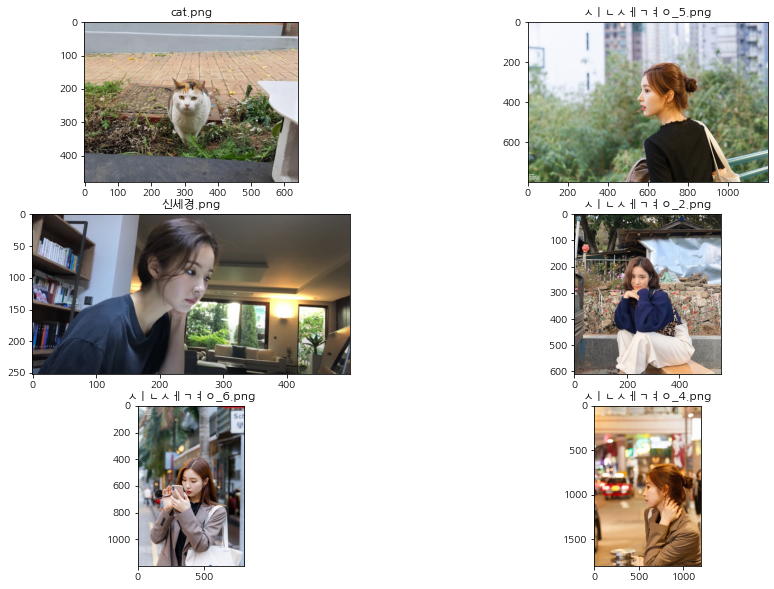

In [139]:
fig, axs = plt.subplots(3,2,figsize=(15,10))
for ax, img in zip(axs.flat, img_list):
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title(os.path.basename(img))
                 
plt.rc('font', family='NanumGothic')
plt.show()

## DeepLab Model 준비하기

In [140]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME='ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME='frozen_inference_graph'
    
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
    
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)
    
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## 이미지 넣어서 시맨틱 세그멘테이션 만들기

In [141]:
img_orig = cv2.imread(img_root_path+'신세경.png')
img_orig.shape

(252, 500, 3)

In [142]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [143]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(252, 500, 3) (258, 513, 3) 18


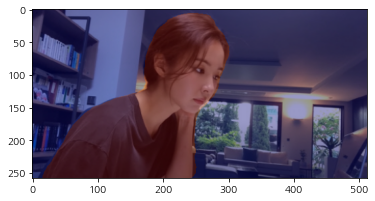

In [144]:
# 사람만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

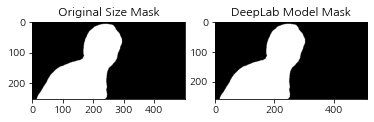

In [145]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 배경을 흐리게 하기

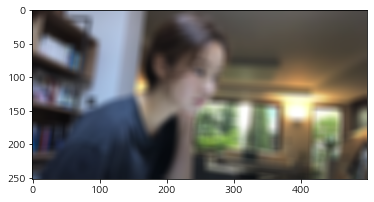

In [146]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

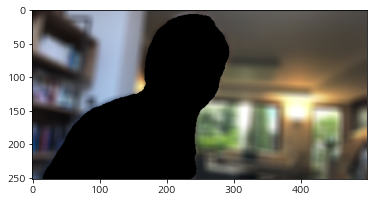

In [147]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 이미지 합성

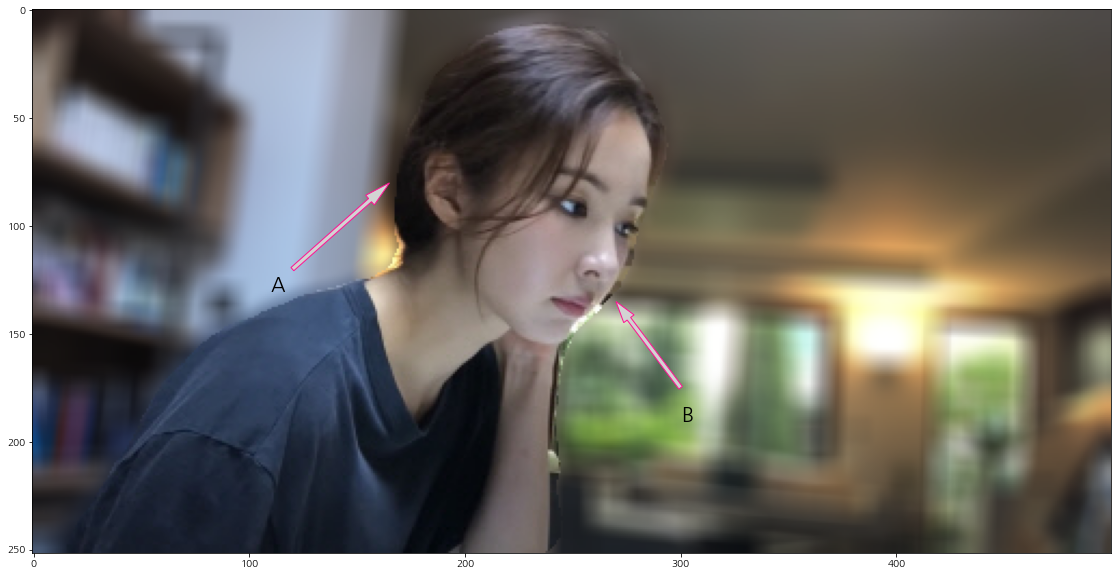

In [148]:
import matplotlib.patches as patches
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(
    patches.Arrow(
        120,120,45,-40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.add_patch(
    patches.Arrow(
        300,175,-30,-40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.text(110, 130, 'A',size=20)
ax.text(300, 190, 'B',size=20)
ax.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


plt.show()

## 문제점

* A: 머리카락 쪽이 블러처리가 되었다.
* B: 경계가 눈에 띄게 분리되었다.
* 가까운데에서 멀리 갈수록 더 흐릿하게 블러처리되어야 자연스럽게 될 것 같다.

## 고양이 사진을 이용한 인물사진모드

In [184]:
img_cat = cv2.imread(img_root_path+'cat.png')
img_cat.shape

(480, 640, 3)

In [185]:
img_resized, seg_map = MODEL.run(img_cat)
print(img_cat.shape, img_resized.shape, seg_map.max())

(480, 640, 3) (384, 513, 3) 8


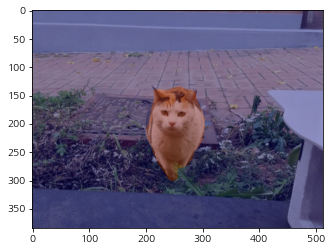

In [186]:
# 고양이만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

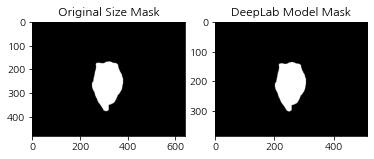

In [187]:
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경을 흐리게 하기

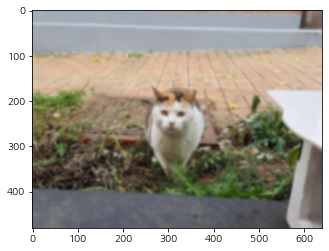

In [188]:
img_cat_blur = cv2.GaussianBlur(img_cat, (13,13),  sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

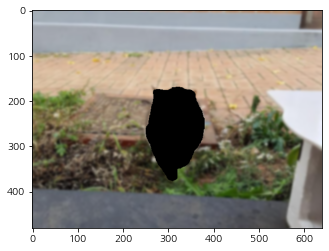

In [189]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지 합성

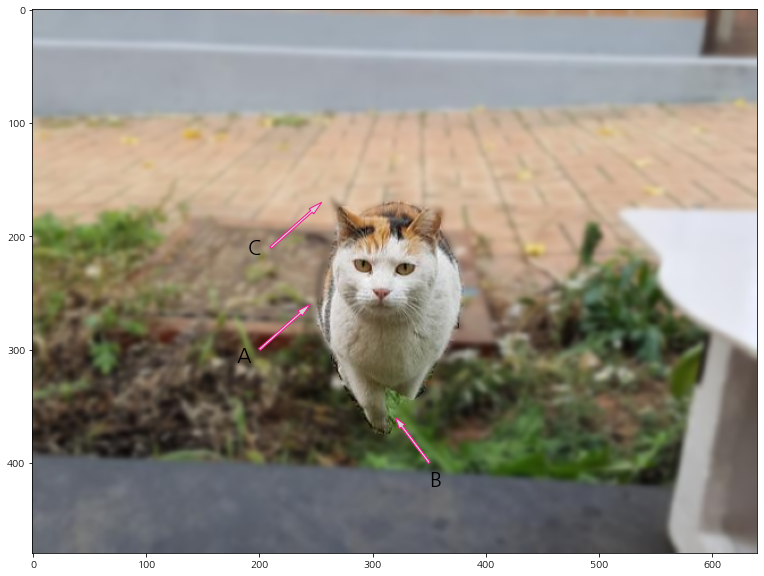

In [198]:
import matplotlib.patches as patches
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(
    patches.Arrow(
        200,300,45,-40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.add_patch(
    patches.Arrow(
        350,400,-30,-40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.add_patch(
    patches.Arrow(
        210,210,45,-40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.text(180, 310, 'A',size=20)
ax.text(350, 420, 'B',size=20)
ax.text(190, 215, 'C',size=20)
ax.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


plt.show()

### 문제점

* A: 점차 흐려져야 하는데 배경 부분이 동일하게 흐려진다.
* B: 다리쪽은 살짝 흐려져도 괜찮을 것 같다.
* C: 부드럽게 blur처리를 하기 위해 가우시안 블러를 사용했는데 귀 부분이 부자연스럽게 블러처리가 되었다.

## 배경전환 크로마키 사진

In [177]:
img_cat = cv2.imread(img_root_path+'cat2.png')
img_cat.shape

(510, 339, 3)

In [178]:
img_resized, seg_map = MODEL.run(img_cat)
print(img_cat.shape, img_resized.shape, seg_map.max())

(510, 339, 3) (513, 340, 3) 8


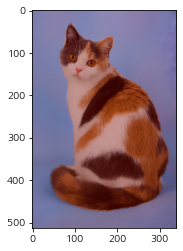

In [179]:
# 고양이만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

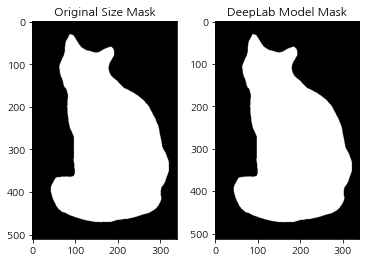

In [180]:
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 바꾸기

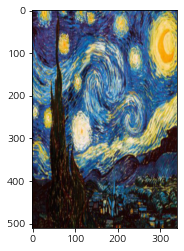

In [181]:
img_background = cv2.imread(img_root_path+'background.png')
img_background = cv2.resize(img_background, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB))
plt.show()

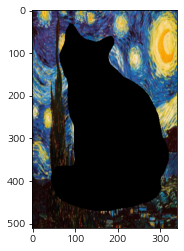

In [182]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_change_bg = cv2.bitwise_and(img_background, img_bg_mask)
plt.imshow(cv2.cvtColor(img_change_bg, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지 합성

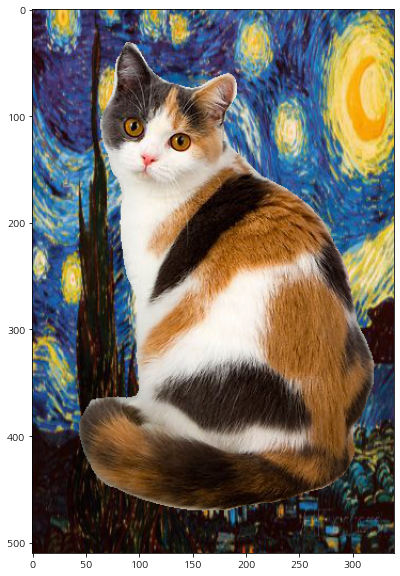

In [183]:
import matplotlib.patches as patches
img_concat = np.where(img_mask_color==255, img_cat, img_change_bg)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


plt.show()

## 문제점을 개선할 수 있는 솔루션
* https://github.com/anilsathyan7/Portrait-Segmentation
* https://www.tensorflow.org/tutorials/images/segmentation#oxford-iiit_pets_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%84%B8%ED%8A%B8%EB%A5%BC_%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C_%ED%95%98%EA%B8%B0


=> 위 링크는 모두 U-Net을 이용해 image segmentation을 진행한 것이다. 

#### U-Net이란?
Image Segmentation을 목적으로 제안된 Full convolutional Network


이 알고리즘을 통해 좀더 세밀안 Image segmentation이 가능할 것 같다.

# 회고

* 사진을 자연스럽게 블러 처리를 하거나 배경을 바꾸고 싶었는데 경계가 구분되게 부자연스럽게 이미지처리가 되어서 좀 아쉬웠다.
* tensorflow v1으로 되어있는 모델이라 자료를 찾는데 조금 어려웠다. v2로 바꿨어야 했나??

# Reference

* https://bkshin.tistory.com/entry/OpenCV-17-%ED%95%84%ED%84%B0Filter%EC%99%80-%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98Convolution-%EC%97%B0%EC%82%B0-%ED%8F%89%EA%B7%A0-%EB%B8%94%EB%9F%AC%EB%A7%81-%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%AF%B8%EB%94%94%EC%96%B8-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%B0%94%EC%9D%B4%EB%A0%88%ED%84%B0%EB%9F%B4-%ED%95%84%ED%84%B0
* https://www.py4u.net/discuss/219849
* https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef
* https://velog.io/@guide333/U-Net-%EC%A0%95%EB%A6%AC